
Testing n=10:

Testing n=20:

Testing n=50:

Testing n=100:


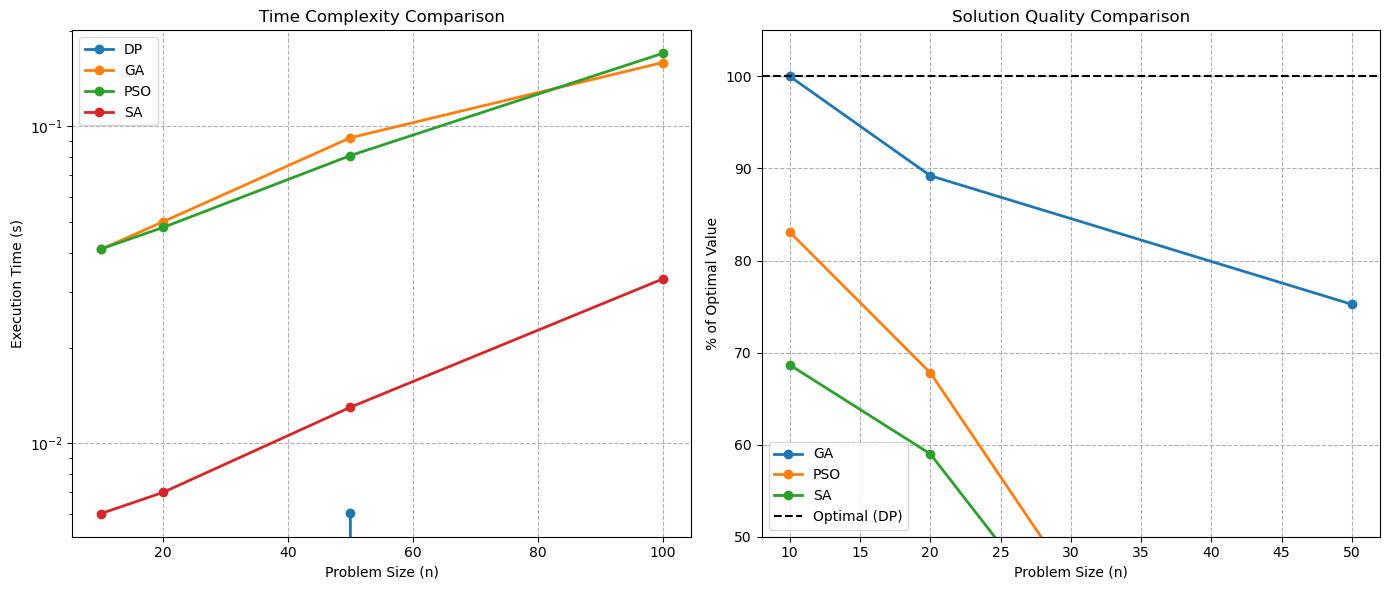


Numerical Results:

Size 10:
DP: 201
GA: 201 (100.0%)
PSO: 167 (83.1%)
SA: 138 (68.7%)

Size 20:
DP: 556
GA: 496 (89.2%)
PSO: 377 (67.8%)
SA: 328 (59.0%)

Size 50:
DP: 1555
GA: 1170 (75.2%)
PSO: 0 (0.0%)
SA: 0 (0.0%)

Size 100:
DP: N/A
GA: 0
PSO: 0
SA: 0


In [1]:
# --- Install Dependencies ---
!pip install numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# ========================
# Algorithm Implementations
# ========================

# 1. Dynamic Programming (Optimal)
def knapsack_dp(values, weights, capacity):
    n = len(values)
    dp = [0]*(capacity + 1)
    for i in range(n):
        for w in range(capacity, weights[i]-1, -1):
            dp[w] = max(dp[w], dp[w - weights[i]] + values[i])
    return dp[capacity]

# 2. Genetic Algorithm
def knapsack_ga(values, weights, capacity, pop_size=50, generations=100, mutation_rate=0.1):
    n = len(values)
    def fitness(chromo):
        total_value = sum(values[i] for i in range(n) if chromo[i])
        total_weight = sum(weights[i] for i in range(n) if chromo[i])
        return total_value if total_weight <= capacity else 0

    pop = [np.random.randint(2, size=n).tolist() for _ in range(pop_size)]

    for _ in range(generations):
        fitness_scores = [fitness(ind) for ind in pop]
        parents = []
        # Tournament selection
        for _ in range(pop_size):
            candidates = random.sample(range(pop_size), 3)
            winner = max(candidates, key=lambda x: fitness_scores[x])
            parents.append(pop[winner])

        # Crossover and mutation
        new_pop = []
        for i in range(0, pop_size, 2):
            p1, p2 = parents[i], parents[i+1]
            pt = random.randint(1, n-1)
            child1 = p1[:pt] + p2[pt:]
            child2 = p2[:pt] + p1[pt:]
            for child in [child1, child2]:
                for j in range(n):
                    if random.random() < mutation_rate:
                        child[j] ^= 1
                new_pop.append(child)
        pop = new_pop

    return max([fitness(ind) for ind in pop])

# 3. Particle Swarm Optimization
def knapsack_pso(values, weights, capacity, num_particles=30, iterations=100):
    n = len(values)
    class Particle:
        def __init__(self):
            self.position = np.random.rand(n)
            self.velocity = np.zeros(n)
            self.best_position = self.position.copy()
            self.best_value = 0

    def evaluate(pos):
        total_value = sum(values[i] for i in range(n) if pos[i] > 0.5)
        total_weight = sum(weights[i] for i in range(n) if pos[i] > 0.5)
        return total_value if total_weight <= capacity else 0

    swarm = [Particle() for _ in range(num_particles)]
    gbest_value = 0
    gbest_position = np.random.rand(n)

    for _ in range(iterations):
        for p in swarm:
            current_value = evaluate(p.position)
            if current_value > p.best_value:
                p.best_value = current_value
                p.best_position = p.position.copy()
            if current_value > gbest_value:
                gbest_value = current_value
                gbest_position = p.position.copy()

        for p in swarm:
            p.velocity = (0.5 * p.velocity +
                         1.5 * (p.best_position - p.position) +
                         1.5 * (gbest_position - p.position))
            p.position = np.clip(p.position + p.velocity, 0, 1)

    return gbest_value

# 4. Simulated Annealing
def knapsack_sa(values, weights, capacity, initial_temp=1000, cooling_rate=0.95):
    n = len(values)
    current = np.random.randint(2, size=n).tolist()

    def evaluate(solution):
        total_value = sum(values[i] for i in range(n) if solution[i])
        total_weight = sum(weights[i] for i in range(n) if solution[i])
        return total_value if total_weight <= capacity else 0

    current_value = evaluate(current)
    best_value = current_value
    temp = initial_temp

    for _ in range(1000):
        neighbor = current.copy()
        idx = random.randint(0, n-1)
        neighbor[idx] ^= 1
        neighbor_value = evaluate(neighbor)

        if neighbor_value > current_value or random.random() < np.exp((neighbor_value - current_value)/temp):
            current = neighbor
            current_value = neighbor_value
            if current_value > best_value:
                best_value = current_value

        temp *= cooling_rate

    return best_value

# ========================
# Performance Comparison
# ========================

# Test parameters
sizes = [10, 20, 50, 100]  # Problem sizes to test
capacity_scale = 5         # Capacity = size * scale

# Results storage
results = {
    'DP': {'time': [], 'value': []},
    'GA': {'time': [], 'value': []},
    'PSO': {'time': [], 'value': []},
    'SA': {'time': [], 'value': []}
}

for size in sizes:
    print(f"\nTesting n={size}:")
    # Generate random problem instance
    values = np.random.randint(10, 100, size)
    weights = np.random.randint(5, 30, size)
    capacity = size * capacity_scale

    # 1. Run DP (only for small instances)
    if size <= 50:
        start = time.time()
        dp_result = knapsack_dp(values, weights, capacity)
        dp_time = time.time() - start
        results['DP']['time'].append(dp_time)
        results['DP']['value'].append(dp_result)
    else:
        results['DP']['time'].append(None)
        results['DP']['value'].append(None)

    # 2. Run GA
    start = time.time()
    ga_result = knapsack_ga(values, weights, capacity)
    results['GA']['time'].append(time.time() - start)
    results['GA']['value'].append(ga_result)

    # 3. Run PSO
    start = time.time()
    pso_result = knapsack_pso(values, weights, capacity)
    results['PSO']['time'].append(time.time() - start)
    results['PSO']['value'].append(pso_result)

    # 4. Run SA
    start = time.time()
    sa_result = knapsack_sa(values, weights, capacity)
    results['SA']['time'].append(time.time() - start)
    results['SA']['value'].append(sa_result)

# ========================
# Plotting Results
# ========================

plt.figure(figsize=(14, 6))

# Time Complexity Plot
plt.subplot(1, 2, 1)
for algo in ['DP', 'GA', 'PSO', 'SA']:
    x = [sizes[i] for i, t in enumerate(results[algo]['time']) if t is not None]
    y = [t for t in results[algo]['time'] if t is not None]
    plt.plot(x, y, marker='o', label=algo, linewidth=2)

plt.xlabel('Problem Size (n)')
plt.ylabel('Execution Time (s)')
plt.title('Time Complexity Comparison')
plt.yscale('log')
plt.grid(True, linestyle='--')
plt.legend()

# Solution Quality Plot
plt.subplot(1, 2, 2)
for algo in ['GA', 'PSO', 'SA']:
    x = []
    y = []
    for i, size in enumerate(sizes):
        if results['DP']['value'][i] is not None and results[algo]['value'][i] is not None:
            x.append(size)
            y.append(results[algo]['value'][i] / results['DP']['value'][i] * 100)
    plt.plot(x, y, marker='o', label=algo, linewidth=2)

plt.xlabel('Problem Size (n)')
plt.ylabel('% of Optimal Value')
plt.title('Solution Quality Comparison')
plt.axhline(100, color='black', linestyle='--', label='Optimal (DP)')
plt.ylim(50, 105)
plt.grid(True, linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

# Print Numerical Results
print("\nNumerical Results:")
for size, dp_val, ga_val, pso_val, sa_val in zip(
    sizes,
    results['DP']['value'],
    results['GA']['value'],
    results['PSO']['value'],
    results['SA']['value']
):
    print(f"\nSize {size}:")
    print(f"DP: {dp_val if dp_val else 'N/A'}")
    print(f"GA: {ga_val} ({ga_val/dp_val*100:.1f}%)" if dp_val else f"GA: {ga_val}")
    print(f"PSO: {pso_val} ({pso_val/dp_val*100:.1f}%)" if dp_val else f"PSO: {pso_val}")
    print(f"SA: {sa_val} ({sa_val/dp_val*100:.1f}%)" if dp_val else f"SA: {sa_val}")
  